In [1]:
import numpy as np
import torch as pt
import nibabel as nb
import nitools as nt
import pandas as pd
import glob 
import matplotlib.pyplot as plt
import Functional_Fusion.atlas_map as am
import Functional_Fusion.dataset as ds
import HierarchBayesParcel.arrangements as ar
import HierarchBayesParcel.emissions as em
import HierarchBayesParcel.full_model as fm
import HierarchBayesParcel.util as ut
import SUITPy as suit
import Functional_Fusion.plot as plot


In [63]:
#loading probabilistic group atlas 

wk_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Pontine7T/atlases/thalamus'

atlas, _ = am.get_atlas('MNISymThalamus1')

atlas_fname = np.load(f"{wk_dir}/Prob_thalamus.npy")
#comb_hemispheres = atlas_fname[0:16] + atlas_fname[16:32]   

print(atlas_fname.shape)

#print(comb_hemispheres.shape)


(32, 25640)


In [64]:

#setting group probbilistic atlas as prior 

ar_model = ar.build_arrangement_model(atlas_fname, prior_type='prob', atlas=atlas)



/Users/incehusain/Documents/GitHub/HierarchBayesParcel/HierarchBayesParcel/arrangements.py:1879: UserWarning: The marginal probability has 24481 voxels zero values - adding small value to avoid -inf
  warnings.warn(f'The marginal probability has {zero_voxl} voxels'


In [515]:
#creating flat prior 

K = ar_model.K
P = atlas.P

U_flat = np.ones((K, P)) / K    

ar_model_flat = ar.build_arrangement_model(U_flat, prior_type='prob', atlas=atlas)


In [65]:

#loading data 
#MDTB - {s}_space-{atlas.name}_ses-s1_CondRun.dscalar.nii
#Language - {s}_space-{atlas.name}_ses-localizerfm_CondRun.dscalar.nii
#MDTB-high-res - {s}_space-{atlas.name}_ses-s1_CondRun.dscalar.nii

data_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Language'

# Read the participant tsv file to get the name of the available subjects
subj_info = pd.read_csv(f'{data_dir}/participants.tsv',sep='\t')
subj_info = subj_info[subj_info['participant_id'] != 'sub-12']


data = []
# Read the data for each subject
for i, s in enumerate(subj_info['participant_id']):
        file_name = f'{data_dir}/derivatives/ffextract/{s}/{s}_space-{atlas.name}_ses-localizerfm_CondRun.dscalar.nii'
        datafile = nb.load(file_name)
        data.append(datafile.get_fdata())
# make the numsubj x numcond (16 repetitions x 9 conditions) x numvoxel tensor
data = np.stack(data)
data.shape

np.save(f"{wk_dir}/indiv_parcellations/Language/Language_data.npy", data)


In [66]:
#info organization for emission model

#MDTB - sub-02_ses-s1_CondRun.tsv (cond_name)
#Language - sub-01_ses-localizerfm_CondRun.tsv (task_name)
#MDTB-high-res - sub-01_ses-s1_CondRun.tsv (task_name)

info = pd.read_csv(f'{data_dir}/derivatives/ffextract/sub-01/sub-01_ses-localizerfm_CondRun.tsv',sep='\t')
cond_v = info['task_name'].values #condition number
part_v = info['run'].values #number of runs 

data = ds.remove_baseline(data,part_v) #for language, pontine 

cond_v

array(['rest', 'word_reading', 'verb_GENERATION',
       'action_observation_action', 'action_observation_knot',
       'intact_passage', 'degraded_passage', 'tongue_movement',
       'finger_sequence', 'theory_of_mind', 'auditory_narrative',
       'n_back', 'oddball', 'demand_grid', 'romance_movie',
       'spatial_navigation', 'sentence_reading', 'nonword_reading',
       'rest', 'word_reading', 'verb_GENERATION',
       'action_observation_action', 'action_observation_knot',
       'intact_passage', 'degraded_passage', 'tongue_movement',
       'finger_sequence', 'theory_of_mind', 'auditory_narrative',
       'n_back', 'oddball', 'demand_grid', 'romance_movie',
       'spatial_navigation', 'sentence_reading', 'nonword_reading',
       'rest', 'word_reading', 'verb_GENERATION',
       'action_observation_action', 'action_observation_knot',
       'intact_passage', 'degraded_passage', 'tongue_movement',
       'finger_sequence', 'theory_of_mind', 'auditory_narrative',
       'n_back'

In [79]:
#data only parcellation 

#building individual parcellations 

K = ar_model.K

# Make a design matrix
X= ut.indicator(cond_v)

# Build an emission model
em_model = em.MixVMF(K=K,P=atlas.P, X=X,part_vec=part_v)

em_model.V = pt.load(f"{wk_dir}/V_cerebcortex_Language.pt")

em_model.set_param_list(['kappa'])

# Build the full model: The emission models are passed as a list, as usually we have multiple data sets
M = fm.FullMultiModel(ar_model, [em_model])

# Attach the data to the model - this is done for speed
# The data is passed as a list with on element per data set

M.initialize([data])

# Now we can run the EM algorithm
M, _, _, _ = M.fit_em(iter=200, tol=0.01,
    fit_arrangement=False,fit_emission=True,first_evidence=False)


#for data-driven parcellations:  # Run E-step

emloglik = M.emissions[0].Estep()
U_indiv_data_only = pt.softmax(emloglik, dim=1)
U_indiv_group, _ = M.arrange.Estep(emloglik)    

#for new subjects added to dataset later 
M.initialize([data])
U_indiv_group,_ = M.Estep()




/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_96483/2551462714.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  em_model.V = pt.load(f"{wk_dir}/V_cerebcorte

In [82]:
print("data only", U_indiv_data_only.shape)

print("group", U_indiv_group.shape)

data only torch.Size([16, 32, 25640])
group torch.Size([16, 32, 25640])


In [518]:
#building individual parcellations with group 

K = ar_model.K

# Make a design matrix
X= ut.indicator(cond_v)

# Build an emission model
em_model = em.MixVMF(K=K,P=atlas.P, X=X,part_vec=part_v)

em_model.V = pt.load(f"{wk_dir}/V_cerebcortex_Pontine.pt")

em_model.set_param_list(['kappa'])

# Build the full model: The emission models are passed as a list, as usually we have multiple data sets
M = fm.FullMultiModel(ar_model, [em_model])

# Attach the data to the model - this is done for speed
# The data is passed as a list with on element per data set

M.initialize([data])

# Now we can run the EM algorithm
M, _, _, _ = M.fit_em(iter=200, tol=0.01,
    fit_arrangement=False,fit_emission=True,first_evidence=False)



/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_17116/3034990284.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  em_model.V = pt.load(f"{wk_dir}/V_cerebcorte

In [519]:
#storing individual parcellations

U_indiv,_ = M.Estep()
print(U_indiv.shape)

torch.Size([17, 32, 25640])


In [68]:

#saving each individual parcellation as numpy file

subj_info = pd.read_csv(f"{data_dir}/participants.tsv", sep="\t")
subj_info = subj_info[subj_info['participant_id'] != 'sub-12'].reset_index(drop=True)

subjects = subj_info["participant_id"].tolist()

for y, subj in enumerate(subjects):
    np.save(f"{wk_dir}/indiv_parcellations/Language_data_only/{subj}.npy",U_indiv_data_only[y])  


In [15]:
#saving compiled hard parcellations 

files = sorted(glob.glob(f"{wk_dir}/indiv_parcellations/mdtb(high-res)/*.npy"))

all_parcels = []

for f in files:
    U = np.load(f)  # shape (K, P)
    labels = np.argmax(U, axis=0) + 1  # shape (P,) – assign each voxel to the max-prob parcel
    all_parcels.append(labels)

# Stack into (num_subjects, P)
all_parcels = np.stack(all_parcels, axis=0)

print("Shape:", all_parcels.shape)  # (num_subjects, P)

# Save for use in calc_test_dcbc
np.save(f"{wk_dir}/indiv_parcellations/mdtb(high-res)/all_indiv_parcels.npy", all_parcels)


Shape: (17, 25640)


In [105]:
pmap = np.load(f"{wk_dir}/indiv_parcellations/MDTB_ses1_data_only/sub-06.npy")
pmap2 = np.load(f"{wk_dir}/indiv_parcellations/MDTB-ses1_flat_prior/sub-06.npy")

wta = np.argmax(pmap, axis=0) + 1
wta2 = np.argmax(pmap2, axis=0) + 1


In [92]:
pmap = np.load(f"{wk_dir}/indiv_parcellations/Language/sub-02.npy")

print("pmap", pmap[0])

print("group", U_indiv_group[1][0])


pmap [0.26255837 0.2884572  0.26526812 ... 0.10366436 0.02973288 0.02700445]
group tensor([0.2626, 0.2885, 0.2653,  ..., 0.1037, 0.0297, 0.0270])


In [106]:
print("one", pmap[0])

print("two", pmap2[0])

print("same?", np.array_equal(pmap, pmap2))

print("wta", wta[0])

print("wta2", wta2[0])

np.array_equal(wta, wta2)

one [0.04213337 0.04585287 0.04601848 ... 0.0166477  0.01795128 0.02235507]
two [0.0596413  0.08815109 0.09033716 ... 0.00184303 0.00263037 0.00665875]
same? False
wta 8
wta2 8


True

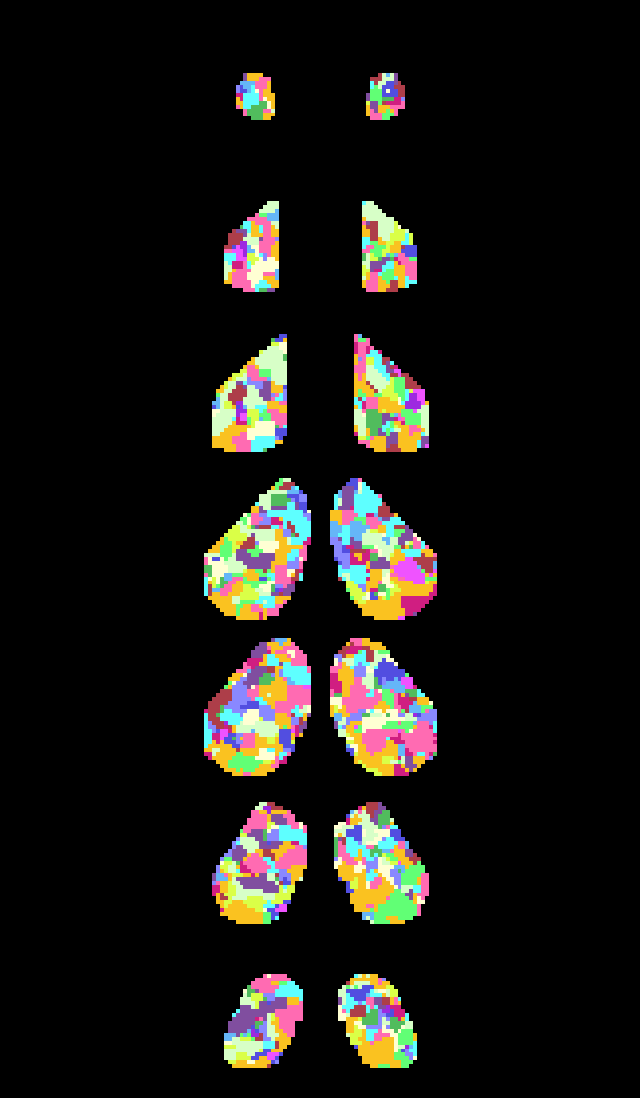

In [78]:
#visualizing individual parcellations

lid,cmap,names = nt.read_lut('/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Atlases/tpl-MNI152NLin2009cSymC/atl-NettekovenSym32.lut')

pmap = np.load(f"{wk_dir}/indiv_parcellations/MDTB_ses1_data_only/sub-06.npy")

#comb_hem = pmap[0:16] + pmap[16:32]   

wta = np.argmax(pmap, axis=0) + 1

wta_int32 = wta.astype(np.int32)

thalamus_parcellation = plot.plot_thalamus(wta_int32, bg_img= None, cscale=[0,32], cmap=cmap)


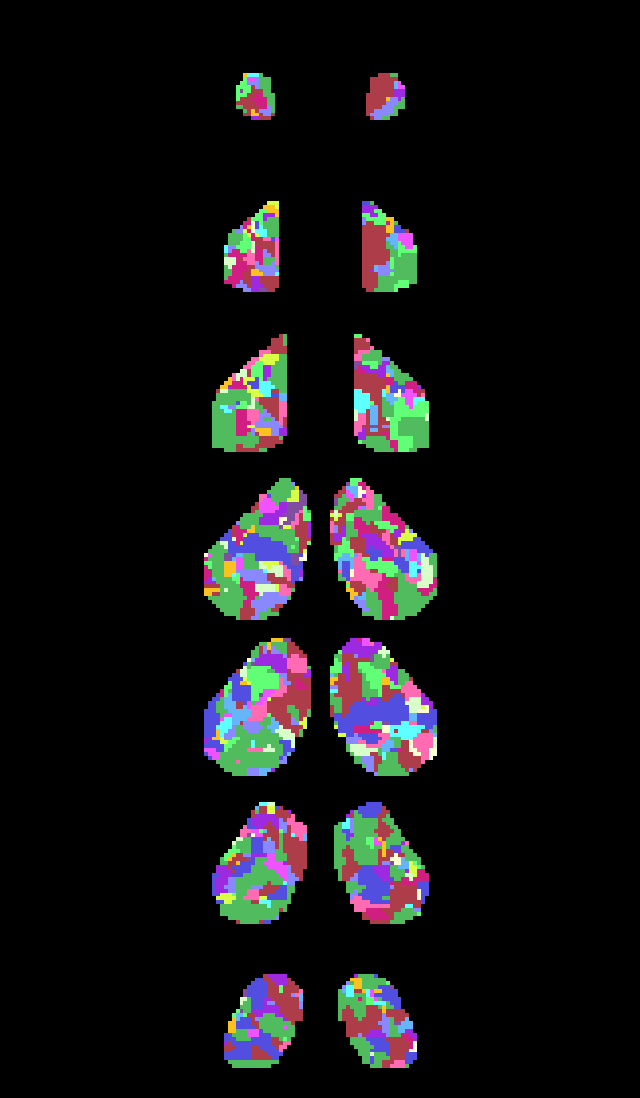

In [347]:
#visualizing individual parcellations #new

lid,cmap,names = nt.read_lut('/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Atlases/tpl-MNI152NLin2009cSymC/atl-NettekovenSym32.lut')

pmap = np.load(f"{wk_dir}/indiv_parcellations/MDTB-ses2/sub-06.npy")

wta = np.argmax(pmap, axis=0) + 1

wta_int32 = wta.astype(np.int32)

thalamus_parcellation = plot.plot_thalamus(wta_int32, bg_img= None, cscale=[0,32], cmap=cmap)


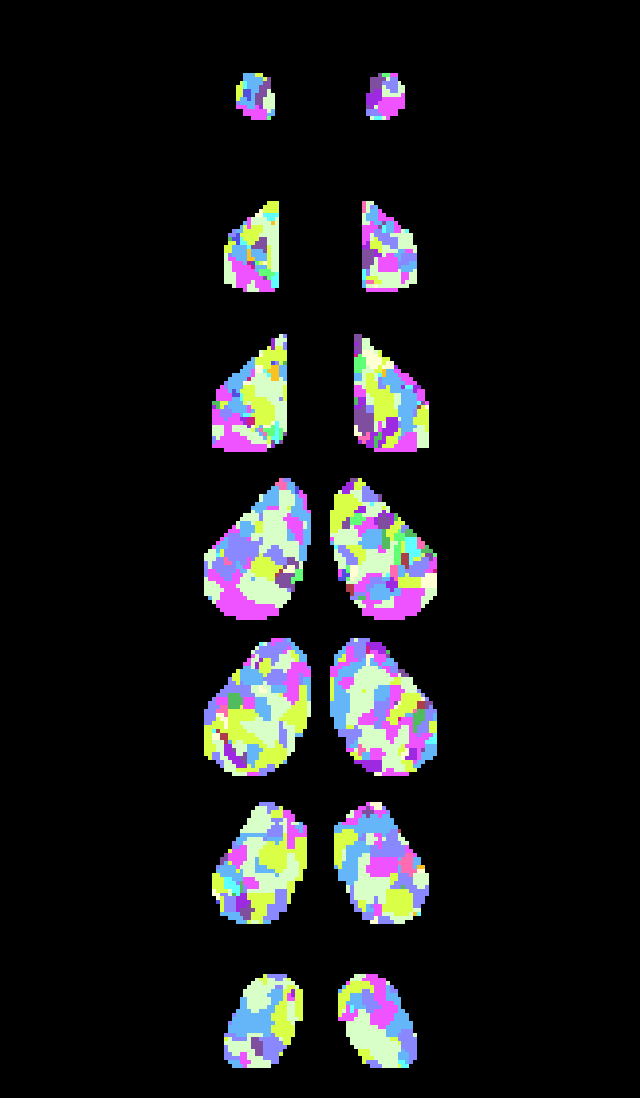

In [332]:
#visualizing individual parcellations #new

lid,cmap,names = nt.read_lut('/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Atlases/tpl-MNI152NLin2009cSymC/atl-NettekovenSym32.lut')

pmap = np.load(f"{wk_dir}/indiv_parcellations/MDTB-ses1_flat_prior/sub-02.npy")

wta = np.argmax(pmap, axis=0) + 1

wta_int32 = wta.astype(np.int32)

thalamus_parcellation = plot.plot_thalamus(wta_int32, bg_img= None, cscale=[0,32], cmap=cmap)


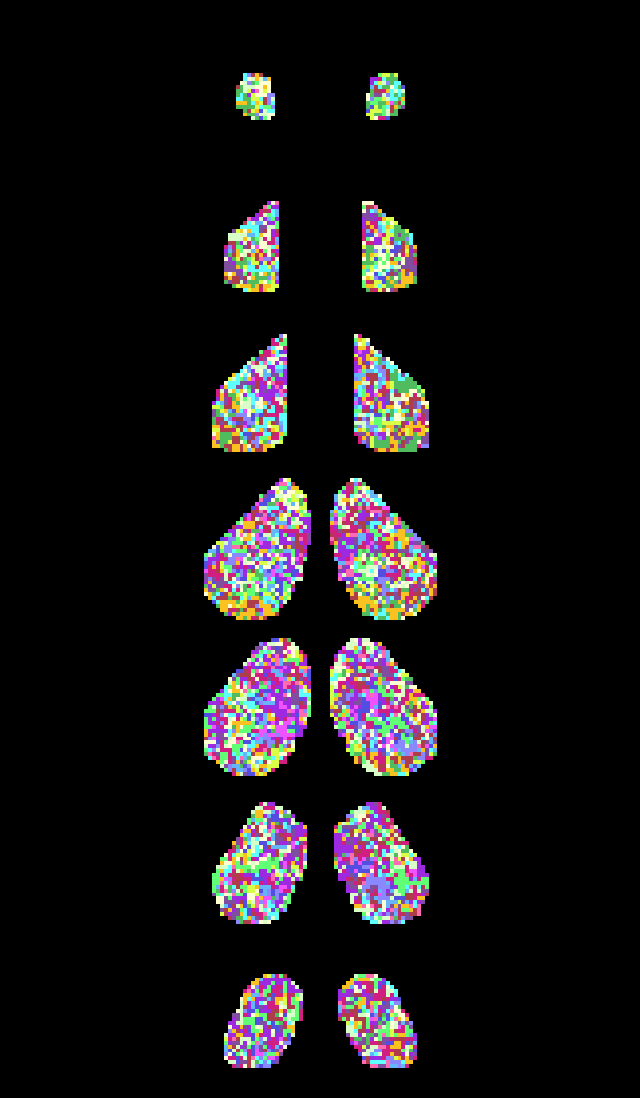

In [422]:
lid,cmap,names = nt.read_lut('/Volumes/diedrichsen_data$/data/FunctionalFusion_new/Atlases/tpl-MNI152NLin2009cSymC/atl-NettekovenSym32.lut')

pmap = np.load(f"{wk_dir}/Prob_thalamus_mdtb(high-res).npy")
comb = pmap[0:16] + pmap[16:32]   

wta = np.argmax(comb, axis=0) + 1

wta_int32 = wta.astype(np.int32)

thalamus_parcellation = plot.plot_thalamus(wta_int32, bg_img= None, cscale=[0,32], cmap=cmap)
